In [34]:
#!pip install gensim
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.utils import resample
from imblearn.under_sampling import RandomUnderSampler
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
#consider adding nltk
import torch
import torch.nn as nn
#!pip install pytorch-lightning
import pytorch_lightning as L
from torch.optim import Adam
import torchmetrics
from pytorch_lightning.callbacks import EarlyStopping
import torchmetrics
from sklearn.metrics import classification_report,confusion_matrix
#!pip install nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [ ]:
df=pd.read_csv('spam_ham_dataset.csv')
df.head()
df['cap']=df['text'].str.count(r'[A-Z]')


In [31]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words=set(stopwords.words('english'))
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [18]:
def remove_stop(text):
  tokens=word_tokenize(text)
  filtered_tokens=[word for word in tokens if word.lower() not in stop_words]
  filtered_text=' '.join(filtered_tokens)
  return filtered_text

In [35]:
lemmatizer = WordNetLemmatizer()
def lem(text):
  tokens=word_tokenize(text)
  lemmatized_tokens=[lemmatizer.lemmatize(word) for word in tokens]
  lemmatized_text=' '.join(lemmatized_tokens)
  return lemmatized_text


In [56]:
splitdata=df['text'].str.split('\n',expand=True)
df['subject']=splitdata[0]
df['body']=splitdata[1]
df['subject']=df['subject'].str.lower()
df['body']=df['body'].str.lower()
df['!']=df['text'].str.count('!')
df['subject']=df['subject'].str.replace("subject:", "", regex=False).str.strip()
df['url']=df['text'].str.count(r'http|www|\.com')
df['digit'] = df['text'].str.count(r'\d')
def vocabratio(text):
    words = text.lower().split()
    if len(words) == 0:
        return 0
    return len(set(words))/len(words)
df['vocabratio'] = df['text'].apply(vocabratio) #helps check the repetition of words
df['wordcount'] = df['text'].apply(lambda x: len(str(x).split()))
df['text'] = df['text'].str.replace(r'[^\w\s]', ' ', regex=True)
df['subject'] = df['text'].str.replace(r'[^\w\s]', ' ', regex=True)
df.head()

,label,text,label_num,cap,subject,body,!,url,digit,vocabratio,wordcount,cleaned_text,body_cleaned
0,ham,Subject enron methanol meter 988291\r\n...,0,1,Subject enron methanol meter 988291\r\n...,this is a follow up to the note i gave you on ...,0,0,10,0.905660,53,Subject enron methanol meter 988291 follow not...,follow note gave monday 4 3 00 preliminary
1,ham,Subject hpl nom for january 9 2001\r\n see...,0,1,Subject hpl nom for january 9 2001\r\n see...,see attached file hplnol 09 xls \r,0,0,9,0.812500,16,Subject hpl nom january 9 2001 see attached fi...,see attached file hplnol 09 xl
2,ham,Subject neon retreat\r\nho ho ho we re ar...,0,1,Subject neon retreat\r\nho ho ho we re ar...,ho ho ho we re around to that most wonderf...,0,1,14,0.469083,469,Subject neon retreat ho ho ho around wonderful...,ho ho ho around wonderful time year neon leade...
3,spam,Subject photoshop windows office cheap ...,1,1,Subject photoshop windows office cheap ...,abasements darer prudently fortuitous undergone\r,0,0,0,1.000000,44,Subject photoshop windows office cheap main tr...,abasement darer prudently fortuitous undergone
4,ham,Subject re indian springs\r\nthis deal is t...,0,1,Subject re indian springs\r\nthis deal is t...,this deal is to book the teco pvr revenue it...,0,0,0,0.765625,64,Subject indian springs deal book teco pvr reve...,deal book teco pvr revenue understanding teco


In [43]:
df['body_cleaned']=df['body'].apply(remove_stop)
df['body_cleaned']=df['body_cleaned'].apply(lem)
df.head()

,label,text,label_num,cap,subject,body,!,url,digit,vocabratio,wordcount,cleaned_text,body_cleaned
0,ham,Subject enron methanol meter 988291\r\n...,0,1,subject enron methanol meter 988291,this is a follow up to the note i gave you on ...,0,0,10,0.905660,67,Subject enron methanol meter 988291 follow not...,follow note gave monday 4 3 00 preliminary
1,ham,Subject hpl nom for january 9 2001\r\n see...,0,1,subject hpl nom for january 9 2001,see attached file hplnol 09 xls \r,0,0,9,0.812500,23,Subject hpl nom january 9 2001 see attached fi...,see attached file hplnol 09 xl
2,ham,Subject neon retreat\r\nho ho ho we re ar...,0,1,subject neon retreat,ho ho ho we re around to that most wonderf...,0,1,14,0.469083,550,Subject neon retreat ho ho ho around wonderful...,ho ho ho around wonderful time year neon leade...
3,spam,Subject photoshop windows office cheap ...,1,1,subject photoshop windows office cheap ...,abasements darer prudently fortuitous undergone\r,0,0,0,1.000000,48,Subject photoshop windows office cheap main tr...,abasement darer prudently fortuitous undergone
4,ham,Subject re indian springs\r\nthis deal is t...,0,1,subject re indian springs,this deal is to book the teco pvr revenue it...,0,0,0,0.765625,70,Subject indian springs deal book teco pvr reve...,deal book teco pvr revenue understanding teco


/tmp/ipython-input-3925628125.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y=col, data=df, ax=axes[i], palette="Set2", showfliers=False)
/tmp/ipython-input-3925628125.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y=col, data=df, ax=axes[i], palette="Set2", showfliers=False)
/tmp/ipython-input-3925628125.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y=col, data=df, ax=axes[i], palette="Set2", showfliers=False)
/tmp/ipython-input-3925628125.py:8: FutureWarning: 

Passing `palette` without ass

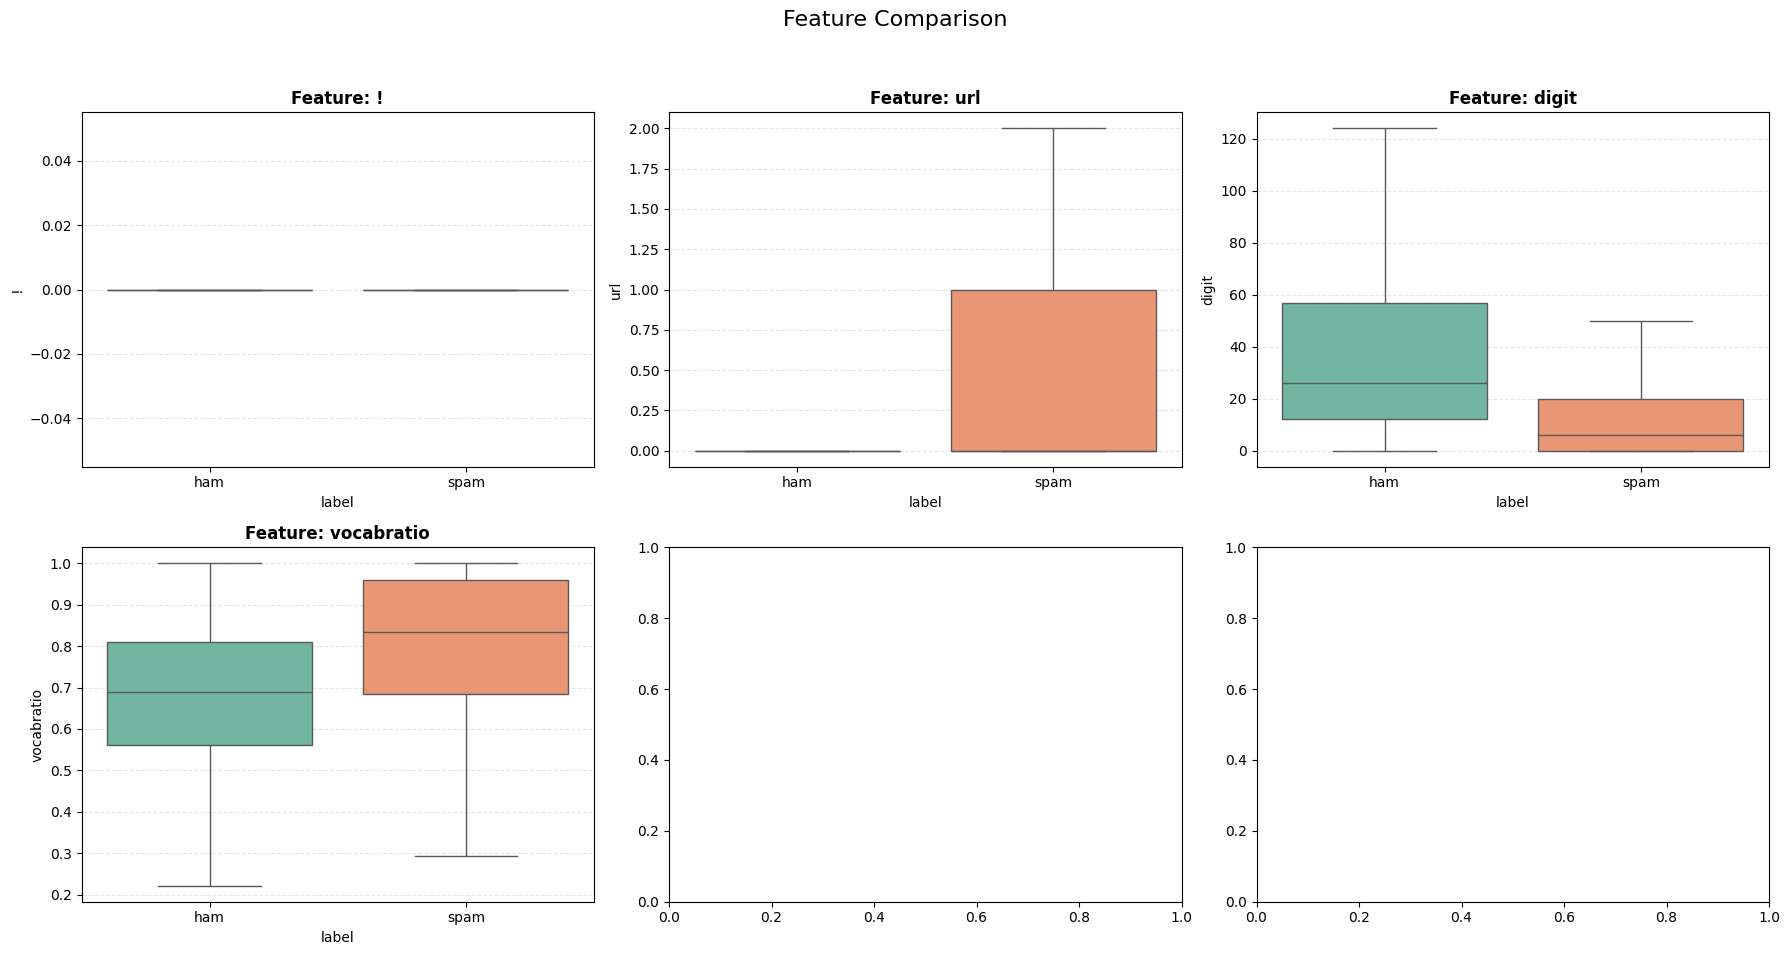

In [44]:
features = [ '!','url','digit','vocabratio']

fig,axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(features):
    if col in df.columns:
        sns.boxplot(x='label', y=col, data=df, ax=axes[i], palette="Set2", showfliers=False)

        axes[i].set_title(f'Feature: {col}', fontsize=12, fontweight='bold')
        axes[i].grid(axis='y', linestyle='--', alpha=0.3)
    else:
        axes[i].set_visible(False)

plt.suptitle('Feature Comparison', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [45]:
vectorizer=CountVectorizer()


In [46]:
df_train,df_test=train_test_split(df,test_size=0.2,random_state=42)


X_train_text=df_train['text']
X_test_text=df_test['text']



feature_cols=['cap','!','url','digit','vocabratio']

X_train_features=df_train[feature_cols]
X_test_features=df_test[feature_cols]

X_train_count=vectorizer.fit_transform(X_train_text)
X_test_count=vectorizer.transform(X_test_text)




y_train=df_train['label_num']
y_test=df_test['label_num']
nb=MultinomialNB()
nb.fit(X_train_count,y_train)

train_bayes=nb.predict(X_train_count)
test_bayes=nb.predict(X_test_count)

X_train_features = X_train_features.copy()
X_train_features.loc[:,'bayes']=train_bayes

X_test_features=X_test_features.copy()
X_test_features.loc[:,'bayes']=test_bayes
print(f"Train Text: {len(X_train_text)}")
print(f"Train Feats: {len(X_train_features)}")


Train Text: 4136
Train Feats: 4136


In [47]:
rus = RandomUnderSampler(sampling_strategy='majority', random_state=42)
#downsampling the data
X_train_text_df = X_train_text.to_frame(name='text_content')

combined_X_train=pd.concat([X_train_features,X_train_text_df], axis=1)
resampled_combined_X_train,resampled_y_train=rus.fit_resample(combined_X_train, y_train)
X_train_features=resampled_combined_X_train[X_train_features.columns]
X_train_text=resampled_combined_X_train['text_content']
y_train=resampled_y_train


In [48]:
train_sentences = [text.split() for text in X_train_text]

w2v_model = Word2Vec(sentences=train_sentences, vector_size=300,  window=5, min_count=1, workers=4)
#each vector(word) has 300 values, window means how many words left and right the word looks to understand,

#w2v uses a shallow nn to train
#similar numbers have small euclidean distance
MAX_LEN=100 #100 words per email
EMBED_DIM=300 #300 numbers per word
#building the 3d tensor

def text_to_vectors(text_series, model, max_len, embed_dim):
    num_samples=len(text_series)#number of emails
    matrix=np.zeros((num_samples, max_len, embed_dim),dtype=np.float32)#len=num_samples(number of emails), width=max_len(number of words per mail)
    #iterating through the words
    for i, text in enumerate(text_series):
        words=text.split()#tokenizes the sentence
        for t, word in enumerate(words): #t is time step tacks position of word
            if t>=max_len:#if it crosses 100 words
                break
            #basically making sure the model skips over unknown words
            if word in model.wv:
                matrix[i, t, :] = model.wv[word] #email i, word t, paste the 300 word vector into that slot

    return matrix

X_train_vectors=text_to_vectors(X_train_text, w2v_model, MAX_LEN, EMBED_DIM)
X_test_vectors=text_to_vectors(X_test_text, w2v_model, MAX_LEN, EMBED_DIM)
print(f"Final Train Shape: {X_train_vectors.shape}")

Final Train Shape: (2412, 100, 300)


In [49]:
class SpamDataset(Dataset):
  #class acts as a container , bundles the data together and adds functions
    def __init__(self, text_tensor, feature_tensor, label_tensor):

      #expects 3 features- 3d text, 2d feautes, 1d classification label
        self.text = torch.tensor(text_tensor)
        self.features = torch.tensor(feature_tensor, dtype=torch.float32)
        self.labels = torch.tensor(label_tensor, dtype=torch.float32)

    def __len__(self): #how many emils, to define when an epoch os finished
        return len(self.labels)

    def __getitem__(self, idx): #grabs that id number and puts the text features and label into a tuple

        return self.text[idx], self.features[idx], self.labels[idx]

train_dataset=SpamDataset(X_train_vectors, X_train_features.values, y_train.values)
test_dataset=SpamDataset(X_test_vectors, X_test_features.values, y_test.values)
#x train vectors is 4000*100*300
train_loader=DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader=DataLoader(test_dataset, batch_size=32, shuffle=False)

In [50]:
class lightninglstm(L.LightningModule):
  def __init__(self, embed_dim, num_features, lstm_hidden_size=128, lstm_num_layers=2,bidirectional=True):
    #embed dim=size of word vec= 300num features= engineered columns and added features, hidden size=no. of numbers lstm can hold
    super().__init__()
    self.lstm=nn.LSTM(input_size=embed_dim,hidden_size=lstm_hidden_size,num_layers=lstm_num_layers,batch_first=True,bidirectional=True)
    #making it biirectional reads l to r and r to l
    #basically 2 hidden layers works like 2 separate lstms


    #telling lstm to expect 300 words as the input, btacfirst= true says that the input is [batch,sequence,features] where batch is basically features,+classification

    self.fc=nn.Linear(lstm_hidden_size*2+num_features,1)#fully connected layer,merges my features with lstm memory,
    self.sigmoid=nn.Sigmoid() #ensures final score is between 0 and 1 d=for sigmoid

    self.criterion=nn.BCELoss() # Binary Cross-Entropy Loss for sigmoid output
    self.accuracy=torchmetrics.Accuracy(task='binary') #calculates by correct/total

  def forward(self, text_input, feature_input):#accepts text vectors and features separately
    lstm_out, (hidden, cell) = self.lstm(text_input)#lstm_out basically has what the model thought at each word,
    diff_hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1) #use the hidden state from the last layer

    combined_features=torch.cat((diff_hidden, feature_input), dim=1)#combines its final hidden state(whatever it thinks) with my features
    output=self.fc(combined_features) #outputs a single rawscore(logit)
    prediction=self.sigmoid(output) #converts that to a probability
    return prediction.squeeze(1)#converts col vectir to a flat list

  def configure_optimizers(self):
    optimizer = Adam(self.parameters(), lr=0.001)
    return optimizer

  def training_step(self, batch, batch_idx):
    batch_text,batch_features,batch_y=batch #unpacks the text, features and final class
    batch_y=batch_y.float()
    output=self.forward(batch_text, batch_features)
    loss = self.criterion(output, batch_y)
    self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True) #records the data and outputs etc
    return loss

  def validation_step(self, batch, batch_idx): #checks whether the model is actually learning or not - recieves a batch of data it has not trained before
    batch_text,batch_features, batch_y=batch
    batch_y=batch_y.float()
    output=self.forward(batch_text, batch_features)#pass both text and features
    loss=self.criterion(output, batch_y)#calculates bce
    preds=(output > 0.8).float() #converts into true/false
    acc=self.accuracy(preds, batch_y)
    self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
    self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    batch_text, batch_features, batch_y = batch
    batch_y = batch_y.float()
    output = self.forward(batch_text, batch_features)
    loss = self.criterion(output, batch_y)
    preds = (output > 0.5).float()
    acc = self.accuracy(preds, batch_y)
    self.log("test_loss", loss, on_step=False, on_epoch=True, logger=True)
    self.log("test_acc", acc, on_step=False, on_epoch=True, logger=True)
    return {'test_preds': preds, 'test_labels': batch_y} #returns prediction vs label

In [51]:
num_features_additional=X_train_features.shape[1] #gets the numbers of features

model=lightninglstm(embed_dim=EMBED_DIM, num_features=num_features_additional)


early_stop_callback = EarlyStopping(monitor='val_loss',min_delta=0.00,patience=3,verbose=False,mode='min')
#use valloss to see o=hoew model performs on  unseen data, patience= how many bad epochs the model can tolerate, mode=min mmeans reduce error


trainer = L.Trainer(max_epochs=50, callbacks=[early_stop_callback]) #trainer has epochs, optimizer etc already
trainer.fit(model, train_loader, test_loader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type           ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ lstm      │ LSTM           │  835 K │ train │     0 │
│ 1 │ fc        │ Linear         │    263 │ train │     0 │
│ 2 │ sigmoid   │ Sigmoid        │      0 │ train │     0 │
│ 3 │ criterion │ BCELoss        │      0 │ train │     0 │
│ 4 │ accuracy  │ BinaryAccuracy │      0 │ train │     0 │
└───┴───────────┴────────────────┴────────┴───────┴───────┘

Trainable params: 835 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 835 K                                                                                                
Total estimated model params size (MB): 3                                                                          
Modules in train mode: 5                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

In [52]:
from sklearn.metrics import classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_text,batch_features, batch_y in test_loader:
        batch_text=batch_text.to(model.device)
        batch_features=batch_features.to(model.device)

        logits=model(batch_text,batch_features) #calculated probabilities

        preds=(logits > 0.8).float() #setting the threshold

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())


print(classification_report(all_labels, all_preds, target_names=['Ham', 'Spam']))

#here precision- when the model says spam is it actually spam?, recall is how many of the spams did it catch
#precision more imp because what is imp mail is falsely classified as spam



              precision    recall  f1-score   support

         Ham       0.96      0.98      0.97       742
        Spam       0.95      0.90      0.93       293

    accuracy                           0.96      1035
   macro avg       0.96      0.94      0.95      1035
weighted avg       0.96      0.96      0.96      1035

